In [136]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from PIL import Image
import matplotlib.pyplot as plt

In [137]:
BASE_DIR  = "/kaggle/input/gtsrb-german-traffic-sign"
TRAIN_DIR = os.path.join(BASE_DIR, "Train")

print("BASE_DIR:", BASE_DIR)
print("Train exists:", os.path.isdir(TRAIN_DIR))
print("Some train subfolders:", os.listdir(TRAIN_DIR)[:10])

BASE_DIR: /kaggle/input/gtsrb-german-traffic-sign
Train exists: True
Some train subfolders: ['7', '17', '19', '22', '2', '35', '23', '10', '5', '36']


In [138]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

In [139]:
full_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)  
class_to_idx = full_dataset.class_to_idx            
id_to_internal = {int(k): v for k, v in class_to_idx.items()}

print("\nMapping ClassId -> internal idx:")
for cid in sorted(id_to_internal.keys())[:10]:
    print(cid, "->", id_to_internal[cid])


Mapping ClassId -> internal idx:
0 -> 0
1 -> 1
2 -> 12
3 -> 23
4 -> 34
5 -> 38
6 -> 39
7 -> 40
8 -> 41
9 -> 42


In [140]:
num_classes = len(full_dataset.classes)
print("Кількість класів:", num_classes)

train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
val_size   = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))

Кількість класів: 43
Train size: 31367
Val size: 7842


In [141]:
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

In [142]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = eval_transform

In [143]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)

In [144]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

for param in model.parameters():
    param.requires_grad = False

model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

for param in model.heads.head.parameters():
    param.requires_grad = True

model = model.to(device)

Device: cuda


In [145]:
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-4 
)

In [146]:
max_epochs = 10      
patience   = 2      
min_delta  = 1e-4   

best_val_loss = float("inf")
best_state_dict = None
epochs_no_improve = 0

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

for epoch in range(max_epochs):
    # ---------- TRAIN ----------
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train   = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train   += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_acc      = correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)

    # ---------- VALIDATION ----------
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val   = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val   += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_acc      = correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1}/{max_epochs} | "
        f"train_loss: {avg_train_loss:.4f}, train_acc: {train_acc:.4f} | "
        f"val_loss: {avg_val_loss:.4f}, val_acc: {val_acc:.4f}"
    )

    # ---------- EARLY STOPPING ----------
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        best_state_dict = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}.")
            break

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print("\nLoaded best model weights (minimal val_loss).")


Epoch 1/10 | train_loss: 2.2883, train_acc: 0.4320 | val_loss: 1.6491, val_acc: 0.5741
Epoch 2/10 | train_loss: 1.4080, train_acc: 0.6406 | val_loss: 1.2422, val_acc: 0.6793
Epoch 3/10 | train_loss: 1.1196, train_acc: 0.7188 | val_loss: 1.0363, val_acc: 0.7476
Epoch 4/10 | train_loss: 0.9540, train_acc: 0.7658 | val_loss: 0.9073, val_acc: 0.7788
Epoch 5/10 | train_loss: 0.8422, train_acc: 0.7954 | val_loss: 0.8146, val_acc: 0.7992
Epoch 6/10 | train_loss: 0.7598, train_acc: 0.8164 | val_loss: 0.7457, val_acc: 0.8191
Epoch 7/10 | train_loss: 0.6944, train_acc: 0.8321 | val_loss: 0.6917, val_acc: 0.8301
Epoch 8/10 | train_loss: 0.6431, train_acc: 0.8446 | val_loss: 0.6476, val_acc: 0.8384
Epoch 9/10 | train_loss: 0.6003, train_acc: 0.8548 | val_loss: 0.6089, val_acc: 0.8483
Epoch 10/10 | train_loss: 0.5643, train_acc: 0.8633 | val_loss: 0.5780, val_acc: 0.8549

Loaded best model weights (minimal val_loss).


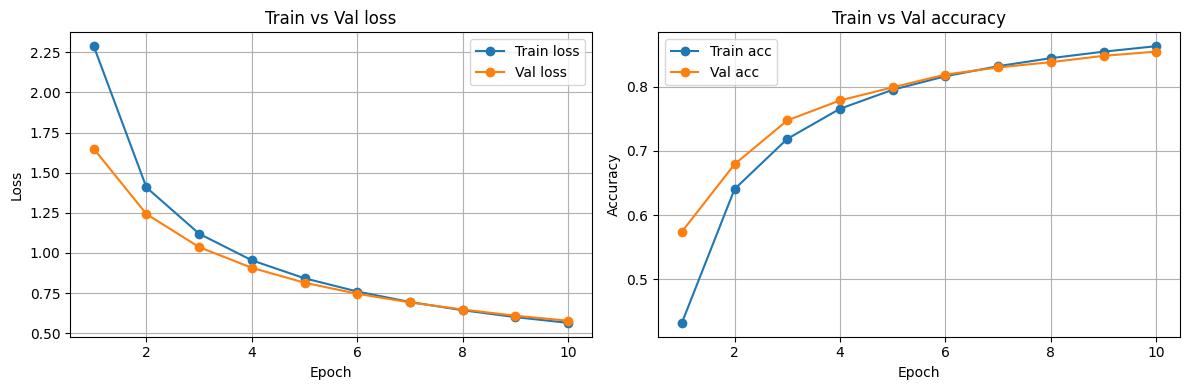

In [147]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, marker="o", label="Train loss")
plt.plot(epochs_range, val_losses,   marker="o", label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, marker="o", label="Train acc")
plt.plot(epochs_range, val_accs,   marker="o", label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [148]:
torch.save(model.state_dict(), "/kaggle/working/vit_gtsrb.pth")

In [149]:
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

BASE_DIR = "/kaggle/input/gtsrb-german-traffic-sign"
TEST_CSV = os.path.join(BASE_DIR, "Test.csv")
TEST_DIR = os.path.join(BASE_DIR, "Test")

test_df = pd.read_csv(TEST_CSV)
print(test_df.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png


In [150]:
class GTSRBTestDataset(Dataset):
    def __init__(self, df, base_dir, class_id_to_idx, transform=None, use_roi=True):
        self.df = df.reset_index(drop=True)
        self.base_dir = base_dir
        self.transform = transform
        self.class_id_to_idx = class_id_to_idx  # мапа ClassId -> internal index
        self.use_roi = use_roi

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_dir, row["Path"])  # e.g. "Test/00000.png"

        img = Image.open(img_path).convert("RGB")

        if self.use_roi:
            x1 = int(row["Roi.X1"])
            y1 = int(row["Roi.Y1"])
            x2 = int(row["Roi.X2"])
            y2 = int(row["Roi.Y2"])
            img = img.crop((x1, y1, x2, y2))

        class_id = int(row["ClassId"])
        label = self.class_id_to_idx[class_id]   

        if self.transform:
            img = self.transform(img)

        return img, label

In [151]:
class_to_idx = full_dataset.class_to_idx
id_to_internal = {int(k): v for k, v in class_to_idx.items()}

test_dataset = GTSRBTestDataset(
    test_df,
    BASE_DIR,
    class_id_to_idx=id_to_internal,
    transform=eval_transform,
    use_roi=True
)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [152]:
print("class_to_idx:", full_dataset.class_to_idx)

print("\nMapping ClassId -> internal idx:")
for cid in sorted(id_to_internal.keys())[:10]:
    print(cid, "->", id_to_internal[cid])

class_to_idx: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42}

Mapping ClassId -> internal idx:
0 -> 0
1 -> 1
2 -> 12
3 -> 23
4 -> 34
5 -> 38
6 -> 39
7 -> 40
8 -> 41
9 -> 42


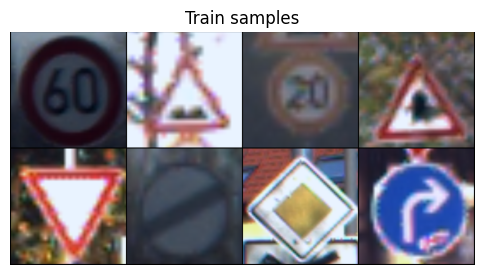

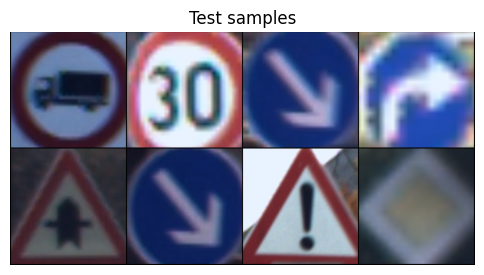

In [153]:
import torchvision

imgs, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(imgs[:8], nrow=4, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Train samples")
plt.axis("off")
plt.show()


imgs_t, labels_t = next(iter(test_loader))
grid_t = torchvision.utils.make_grid(imgs_t[:8], nrow=4, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid_t.permute(1, 2, 0))
plt.title("Test samples")
plt.axis("off")
plt.show()

In [154]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt


In [155]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


accuracy = accuracy_score(all_labels, all_preds)

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average="macro",  
    zero_division=0
)

print(f"Accuracy:          {accuracy:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro):    {recall_macro:.4f}")
print(f"F1-score (macro):  {f1_macro:.4f}")


try:
    class_names = full_dataset.classes
except NameError:
 
    class_names = [str(i) for i in range(len(set(all_labels)))]

print("\nClassification report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    zero_division=0
))

Accuracy:          0.6942
Precision (macro): 0.6698
Recall (macro):    0.5890
F1-score (macro):  0.6005

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.74      0.72      0.73       720
          10       0.52      0.94      0.67       660
          11       0.69      0.89      0.78       420
          12       0.97      0.97      0.97       690
          13       0.91      0.98      0.95       720
          14       0.98      0.91      0.94       270
          15       0.98      0.95      0.96       210
          16       0.98      0.71      0.82       150
          17       0.99      0.95      0.97       360
          18       0.90      0.64      0.75       390
          19       0.32      0.40      0.35        60
           2       0.60      0.70      0.65       750
          20       0.73      0.40      0.52        90
          21       0.90      0.29      0.44        90
       

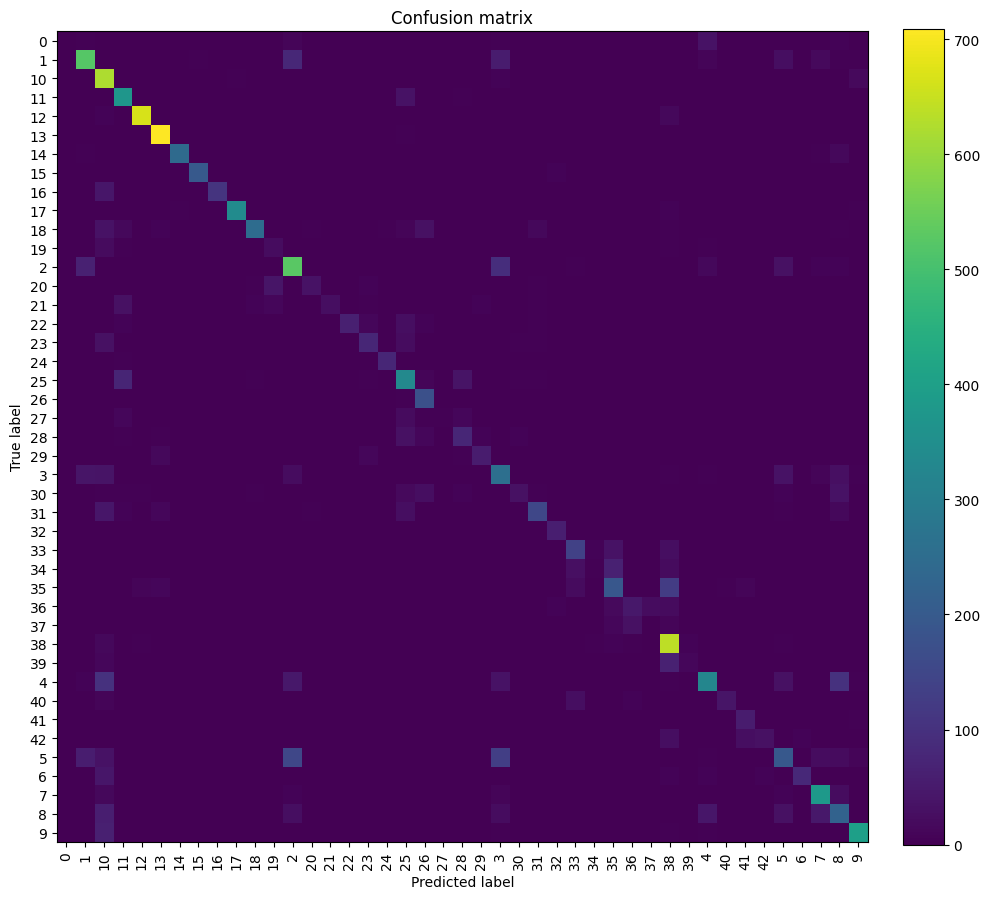

In [156]:
cm = confusion_matrix(all_labels, all_preds)
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
im = plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix")
plt.colorbar(im, fraction=0.046, pad=0.04)

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

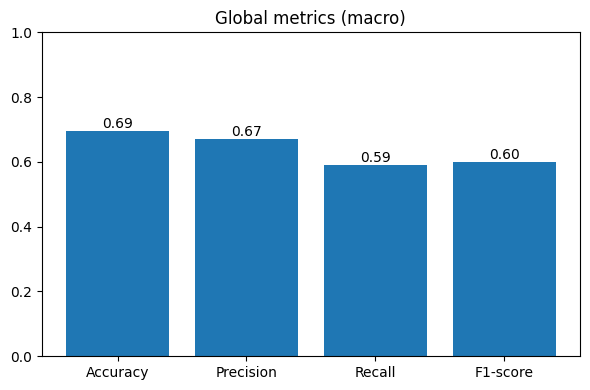

In [157]:
metrics_names = ["Accuracy", "Precision", "Recall", "F1-score"]
metrics_values = [accuracy, precision_macro, recall_macro, f1_macro]

plt.figure(figsize=(6, 4))
plt.bar(metrics_names, metrics_values)
plt.ylim(0, 1.0)
plt.title("Global metrics (macro)")
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()
